# Solución para la predicción de la diabetes

## Modelo de refuerzo

### Opciones y paquetes

In [216]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%config IPCompleter.greedy=True  # Automcompletado rápido
%matplotlib inline
# Asegurarse de que matplotlib use el backend inline para mostrar gráficos en Jupyter
# Hace que los gráficos generados con matplotlib se muestren directamente dentro del notebook, justo debajo de la celda que los genera.



### Importación de datos

In [217]:
train_data = pd.read_csv("Teorico/1. Decision_Tree/data/processed/clean_train.csv")
test_data = pd.read_csv("Teorico/1. Decision_Tree/data/processed/clean_test.csv")

train_data.head()

,Pregnancies,Glucose,BloodPressure,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2.0,84.0,0.0,0.0,0.0,0.3,21.0,0
1,9.0,112.0,82.0,0.0,28.2,1.3,50.0,1
2,1.0,139.0,46.0,83.0,28.7,0.7,22.0,0
3,0.0,161.0,50.0,0.0,21.9,0.3,65.0,0
4,6.0,134.0,80.0,370.0,46.2,0.2,46.0,1


### Modelo

#### Separar train y test

In [218]:
# Como ya importamos el df del proyecto de decision tree, 
# separado en train y test, no es necesario correr este codigo:

# from sklearn.model_selection import train_test_split
# X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

#### Separar predictoras y target

In [219]:
X_train = train_data.drop(["Outcome"], axis = 1)
y_train = train_data["Outcome"]
X_test = test_data.drop(["Outcome"], axis = 1)
y_test = test_data["Outcome"]

#### Entrenar el modelo

In [220]:
from xgboost import XGBClassifier


# Verificar la versión de XGBoost instalada (Recomendado: >= 1.3)

try:    
    from xgboost import __version__ as xgb_version
    print(f"XGBoost version: {xgb_version}")
except ImportError:             
    print("XGBoost no está instalado. Por favor, instale XGBoost para continuar.")
    xgb_version = None

# Verificar si la versión de XGBoost es compatible
if xgb_version is not None:
    major_version = int(xgb_version.split('.')[0])
    minor_version = int(xgb_version.split('.')[1]) if len(xgb_version.split('.')) > 1 else 0
    
    if major_version < 1 or (major_version == 1 and minor_version < 3):
        print("La versión de XGBoost es inferior a la recomendada (>= 1.3). Algunas funcionalidades pueden no estar disponibles.")
    else:
        print("La versión de XGBoost es compatible.")   

XGBoost version: 3.0.0
La versión de XGBoost es compatible.


##### Principales parámetros de CLASIFICACION
<small>
https://xgboost.readthedocs.io/en/latest/python/python_api.html

* learning_rate: cuanto más alto mayor velocidad de aprendizaje. Por defecto 0.1 
* n_estimators: el número de árboles a crear. Por defecto 100. Recomendado entre 100 y 1000, pero cuidado porque puede sobre ajustar
* reg_alpha: regularización en L1
* reg_lambda: regularización en L2
* max_depth: el número de niveles máximo del árbol
* scale_pos_weight: ratio de negativos / positivos para balancear
* n_jobs: número de cores a usar
* gamma: es un parámetro de poda. por defecto es cero que significa no poda, pero si hay altas diferencias entre los  resultados de train y test usar un valor alto como 10

Además hay 3 parámetros especiales porque no se ponen en la instanciación, si no en el fit:

* early_stopping_rounds: es una especie de hiperparametrización interna para ajustar n_estimators. Significa que si pasa del número de iteraciones especificado aquí sin tener mejoras ya no seguirá incrementando n_estimators. Para usarlo hay que pasarle en fit un conjunto de test con eval_set. Un buen número es ponerlo a 5.
* eval_set: es una lista con los predictores de test y la target de test para que ajuste el parámetro anterior. eval_set=[(test_x, test_y)]
* eval_metric: la métrica de evaluación sobre el conjunto de test. Recomiendo poner 'auc'

##### Parametrización recomendada
<small>
Hasta que no cojas experiencia propia puede intimidar el tener que tomar decisiones sobre qué valor dar a los parámetros.

A partir de la experiencia de competiciones en Kaggle se recomiendan que los valores de los parámetros estén entre los siguientes, que puedes usar como punto de partida.

learning_rate = [0.01,0.015,0.025,0.05,0.1]  
gamma = [0.05,0.1,0.3,0.5,0.7,0.9,1,10]  
max_depth = [3,5,7,9,12,15,17,25]  
reg_alpha = [0,0.1,0.5,1]  
reg_lambda = [0.01,0.1,1]

In [243]:
# ◯ Instanciar el clasificador XGBoost y configurar los parámetros
        # ✓ use_label_encoder=False: Evita la advertencia de uso del codificador de etiquetas obsoleto en versiones recientes de XGBoost.
        # ✓ eval_metric='auc': Especifica la métrica de evaluación para el modelo. En este caso, se utiliza AUC (Área bajo la curva ROC), que es común en problemas de clasificación binaria.
        # ✓ early_stopping_rounds=5: Detiene el entrenamiento si no hay mejora en la métrica de evaluación durante 5 rondas consecutivas.
        # ✓ random_state=42: Para reproducibilidad

xgb = XGBClassifier(use_label_encoder=False, eval_metric='auc', early_stopping_rounds=3, random_state=42) 

# Entrenar
xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)])

[0]	validation_0-auc:0.78815
[1]	validation_0-auc:0.80257
[2]	validation_0-auc:0.80349
[3]	validation_0-auc:0.79816
[4]	validation_0-auc:0.78522


/home/vscode/.local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:48:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=3,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

#### Predecir sobre test

In [244]:
# Obtener las probabilidades de la clase positiva (1) para la curva ROC
pred = xgb.predict_proba(X_test)[:, 1] 
# Mostrar las primeras 10 predicciones de probabilidad
pred[:10]

array([0.5413202 , 0.34618944, 0.15256284, 0.18897808, 0.31369388,
       0.5413202 , 0.14308856, 0.54167974, 0.60049456, 0.66000104],
      dtype=float32)

#### Evaluar sobre test

In [245]:
from sklearn.metrics import accuracy_score

# Imprimir la precisión (accuracy) del modelo en el conjunto de prueba
print(f"Accuracy: {accuracy_score(y_test, xgb.predict(X_test)):.4f}")

Accuracy: 0.7403


#### Revisión de los parámetros de entrenamiento

In [246]:
xgb.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': 3,
 'enable_categorical': False,
 'eval_metric': 'auc',
 'feature_types': None,
 'feature_weights': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'use_label_encoder': False}

#### Análisis de la importancia de las variables

XGBoost calcula la importancia de las variables como la ganancia media en todos los nodos en los que se ha usado la variable.

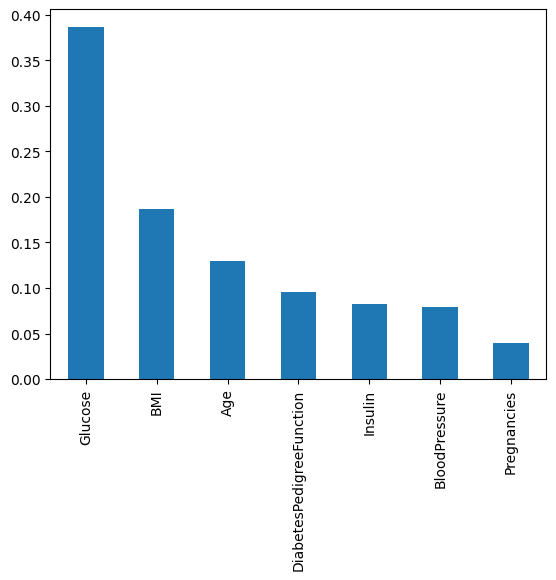

In [247]:
pd.Series(xgb.feature_importances_,index = X_test.columns).sort_values(ascending = False).plot(kind = 'bar');

O un dataframe

In [248]:
importancia = pd.DataFrame({'variable': X_test.columns, 'importancia': xgb.feature_importances_})
importancia.sort_values(by = 'importancia', ascending = False)

,variable,importancia
1,Glucose,0.4
4,BMI,0.2
6,Age,0.1
5,DiabetesPedigreeFunction,0.1
3,Insulin,0.1
2,BloodPressure,0.1
0,Pregnancies,0.0


In [249]:
from xgboost import XGBClassifier

model = XGBClassifier(n_estimators = 800, max_depth=3, learning_rate = 0.001, random_state = 42)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.001, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=800,
              n_jobs=None, num_parallel_tree=None, ...)

In [250]:
y_pred = model.predict(X_test)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

In [251]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.7922077922077922

Este algoritmo de refuerzo es mejor que el árbol de decisión optimizado. (77.2%)

In [252]:
from pickle import dump

dump(model, open("models/boosting_classifier_nestimators-800_learnrate-0.001_42_maxdepth=3.sav", "wb"))